In [10]:
import geobench as gb
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import pickle
import os
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
geo_bench_dir = '/home/vs/Developer/obia-dl-ms-kerner-lab/dataset/geobench'
benchmark_name = 'segmentation_v1.0'
dataset_name = 'm-NeonTree'
dataset_dir = os.path.join(geo_bench_dir, benchmark_name, dataset_name)
dataset_dir

'/home/vs/Developer/obia-dl-ms-kerner-lab/dataset/geobench/segmentation_v1.0/m-NeonTree'

In [12]:
filename = '2018_BART_4_322000_4882000_image_crop_00_00.hdf5'

In [13]:
with h5py.File(os.path.join(dataset_dir, filename), 'r') as f:
    data = list(f.keys())
    print(data)
    print(len(data))

['Blue', 'Canopy Height Model', 'Green', 'Neon', 'Red', 'label']
6


(400, 400, 3) (400, 400) (40, 40, 1) (40, 40, 369)


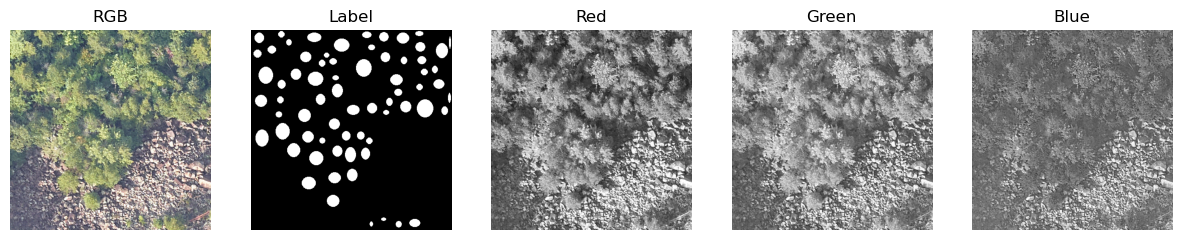

In [14]:
with h5py.File(os.path.join(dataset_dir, filename), 'r') as f:
    data = list(f.keys())
    label = f[data[-1]][:]
    red = f[data[4]][:]
    green = f[data[2]][:]
    blue = f[data[0]][:]
    neon = f[data[3]][:] # hyperspectral image
    ch = f[data[1]][:] # canopy height - elevation model
    
    rgb_image = np.stack((red, green, blue), axis=-1)
    rgb_image = rgb_image.astype(np.uint8)
    print(rgb_image.shape, label.shape, ch.shape, neon.shape)

fig, axs = plt.subplots(1, 5, figsize=(15, 30)) # Adjust figsize as necessary
axs = axs.flatten()
bands = [rgb_image, label, red, green, blue, neon, ch] 

band_names = ['RGB', 'Label', 'Red', 'Green', 'Blue', 'HyperSpectral', 'Canopy Height']

for band, name, ax in zip(bands[:5], band_names[:5], axs):
    ax.imshow(band, cmap='gray')
    ax.set_title(name)
    ax.axis('off')


plt.show()


In [15]:
np.unique(label)

array([0, 1], dtype=uint8)

## now save the rgb image and label separately

(400, 400) 1 0
(400, 400, 3) 255 2
(400, 400, 3) 255 2


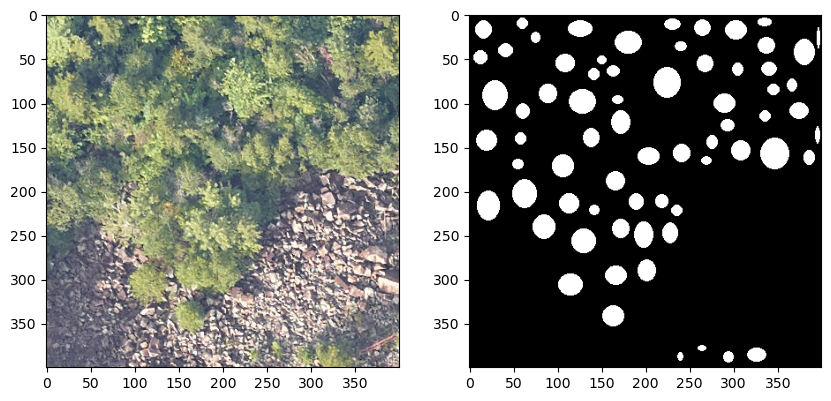

In [16]:
with h5py.File(os.path.join(dataset_dir, filename), 'r') as f:
    data = list(f.keys())
    label = f[data[-1]][:]
    red = f[data[4]][:]
    green = f[data[2]][:]
    blue = f[data[0]][:]

    # Stack the channels to form an RGB image
    image = np.stack((red, green, blue), axis=-1)
    print(label.shape, np.max(label), np.min(label))
    print(image.shape, np.max(image), np.min(image))
    
    # # Check if image.max() is equal to image.min() to avoid division by zero
    # if image.max() > image.min():
    #     # Proceed with normalization if image is not constant
    #     image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    # else:
    #     # If the image is constant, convert directly to uint8 without normalization
    #     # Ensure the data is within the 0-255 range
    #     image = np.clip(image, 0, 255).astype(np.uint8)
    image = image.astype(np.uint8)
    print(image.shape, np.max(image), np.min(image))
    label = label.astype(np.uint8)

    # Convert arrays to PIL images
    image_pil = Image.fromarray(image)
    label_pil = Image.fromarray(label)

    # Display the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs = axs.flatten()
    axs[0].imshow(image_pil, cmap='gray')
    axs[1].imshow(label_pil, cmap='gray')
    

In [17]:
save_dir = '/home/vs/Developer/obia-dl-ms-kerner-lab/neon-tree/neon-tree-rgb-label'
hdf5_dir = dataset_dir

In [18]:
def save_images_and_labels_from_directory(hdf5_dir, save_dir):
    hdf5_dir = Path(hdf5_dir)
    save_dir = Path(save_dir)
    
    # Ensure the save directory exists
    save_dir.mkdir(parents=True, exist_ok=True)
    
    for hdf5_path in hdf5_dir.glob('*.hdf5'):
        with h5py.File(hdf5_path, 'r') as f:
            # Read the datasets for RGB channels and the label
            data = list(f.keys())
            label = f[data[-1]][:]
            red = f[data[4]][:]
            green = f[data[2]][:]
            blue = f[data[0]][:]

            # Stack the channels to form an RGB image
            image = np.stack((red, green, blue), axis=-1)
          
            # For image, label, ensure it's in the correct dtype; no need to scale by 255 for multi-class
            image = image.astype(np.uint8)
            label = label.astype(np.uint8)

            # Convert arrays to PIL images
            image_pil = Image.fromarray(image)
            label_pil = Image.fromarray(label)
            
            # Construct save paths using the original HDF5 file name
            base_name = hdf5_path.stem
            image_save_path = save_dir / f"{base_name}_image.png"
            label_save_path = save_dir / f"{base_name}_label.png"
            
            # Save the image and label
            image_pil.save(image_save_path)
            label_pil.save(label_save_path)

In [19]:
save_images_and_labels_from_directory(hdf5_dir, save_dir)